In [4]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

service = QiskitRuntimeService()

In [44]:
num_qubits =5
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
backend

<IBMBackend('ibm_brussels')>

In [ ]:
class RepetitionCode:
    def __init__(self, d=3, repetitions=2):
        """
        Initialiserar repetitionskoden.
        :param d: Kodens distans
        :param repetitions: Syndrom mätningar
        """
        self.d = d
        self.repetitions = repetitions
        
        # Kvantregister
        self.qreg_data = QuantumRegister(d)  # Kvantbitar
        self.qreg_measure = QuantumRegister(d - 1, name="ancillas")  # Ancilla för syndrommätning
        
        # Klassiska register
        self.creg_data = ClassicalRegister(d, name="final_state")  # Slutlig mätning av datakvantbit
        self.creg_syndrome = [
            ClassicalRegister(d - 1, name=f"syndrome_{i+1}") for i in range(repetitions+1)
        ]

        # Skapa kvantkrets
        self.qc = QuantumCircuit(
            self.qreg_data, self.qreg_measure, self.creg_data, *self.creg_syndrome
        )

    def initialize_qubits(self):
        """Initierar kvantbiten i |1> tillståndet."""

        self.qc.x(self.qreg_data[0]) #X grinden byter |0> -> |1>, eller |1> -> |0>
        self.qc.barrier()            #Barriär tvingar kvantdatorn att göra allt innan (X grinden), innan den kan gå vidare
    
    def bit_flip_encoding(self):
        """Kodning av den logiska kvantbiten."""

        for i in range(1, self.d):  #Sprider tillståndet till de andra kvantbitarna
            self.qc.cx(self.qreg_data[0], self.qreg_data[i]) 
        self.qc.barrier()

    def syndrome_measurement(self):
        """Mäter syndrom och lagrar i klassiska register."""
        for r in range(self.repetitions):           # Antal repetitioner
            for i in range(self.d - 1):             # Syndrom
                self.qc.cx(self.qreg_data[i], self.qreg_measure[i])     
                self.qc.cx(self.qreg_data[i + 1], self.qreg_measure[i])
            self.qc.barrier()
            self.qc.measure(self.qreg_measure, self.creg_syndrome[r])
            self.qc.barrier()

    def final_measurement(self):
        """Mäter slutliga tillståndet av datakvantbit."""
        self.qc.measure(self.qreg_data, self.creg_data)

    def final_measurement2(self):
        """Ersätter den slutgiltiga mätningen med en kvantbitsmätningn och en syndrommätning"""
        for i in range(self.d - 1):             # Syndrom
            self.qc.cx(self.qreg_data[i], self.qreg_measure[i])     
            self.qc.cx(self.qreg_data[i + 1], self.qreg_measure[i])
        self.qc.barrier()
        self.qc.measure(self.qreg_measure, self.creg_syndrome[self.repetitions])
        self.qc.barrier()
        self.qc.measure(self.qreg_data[0], self.creg_data)
        self.qc.barrier()
        
        
    def build_circuit(self):
        """Bygger hela kvantkretsen."""
        self.initialize_qubits()
        self.bit_flip_encoding()
        self.syndrome_measurement()
        self.final_measurement2() # Väld final_measurment eller final_measurement2
        return self.qc


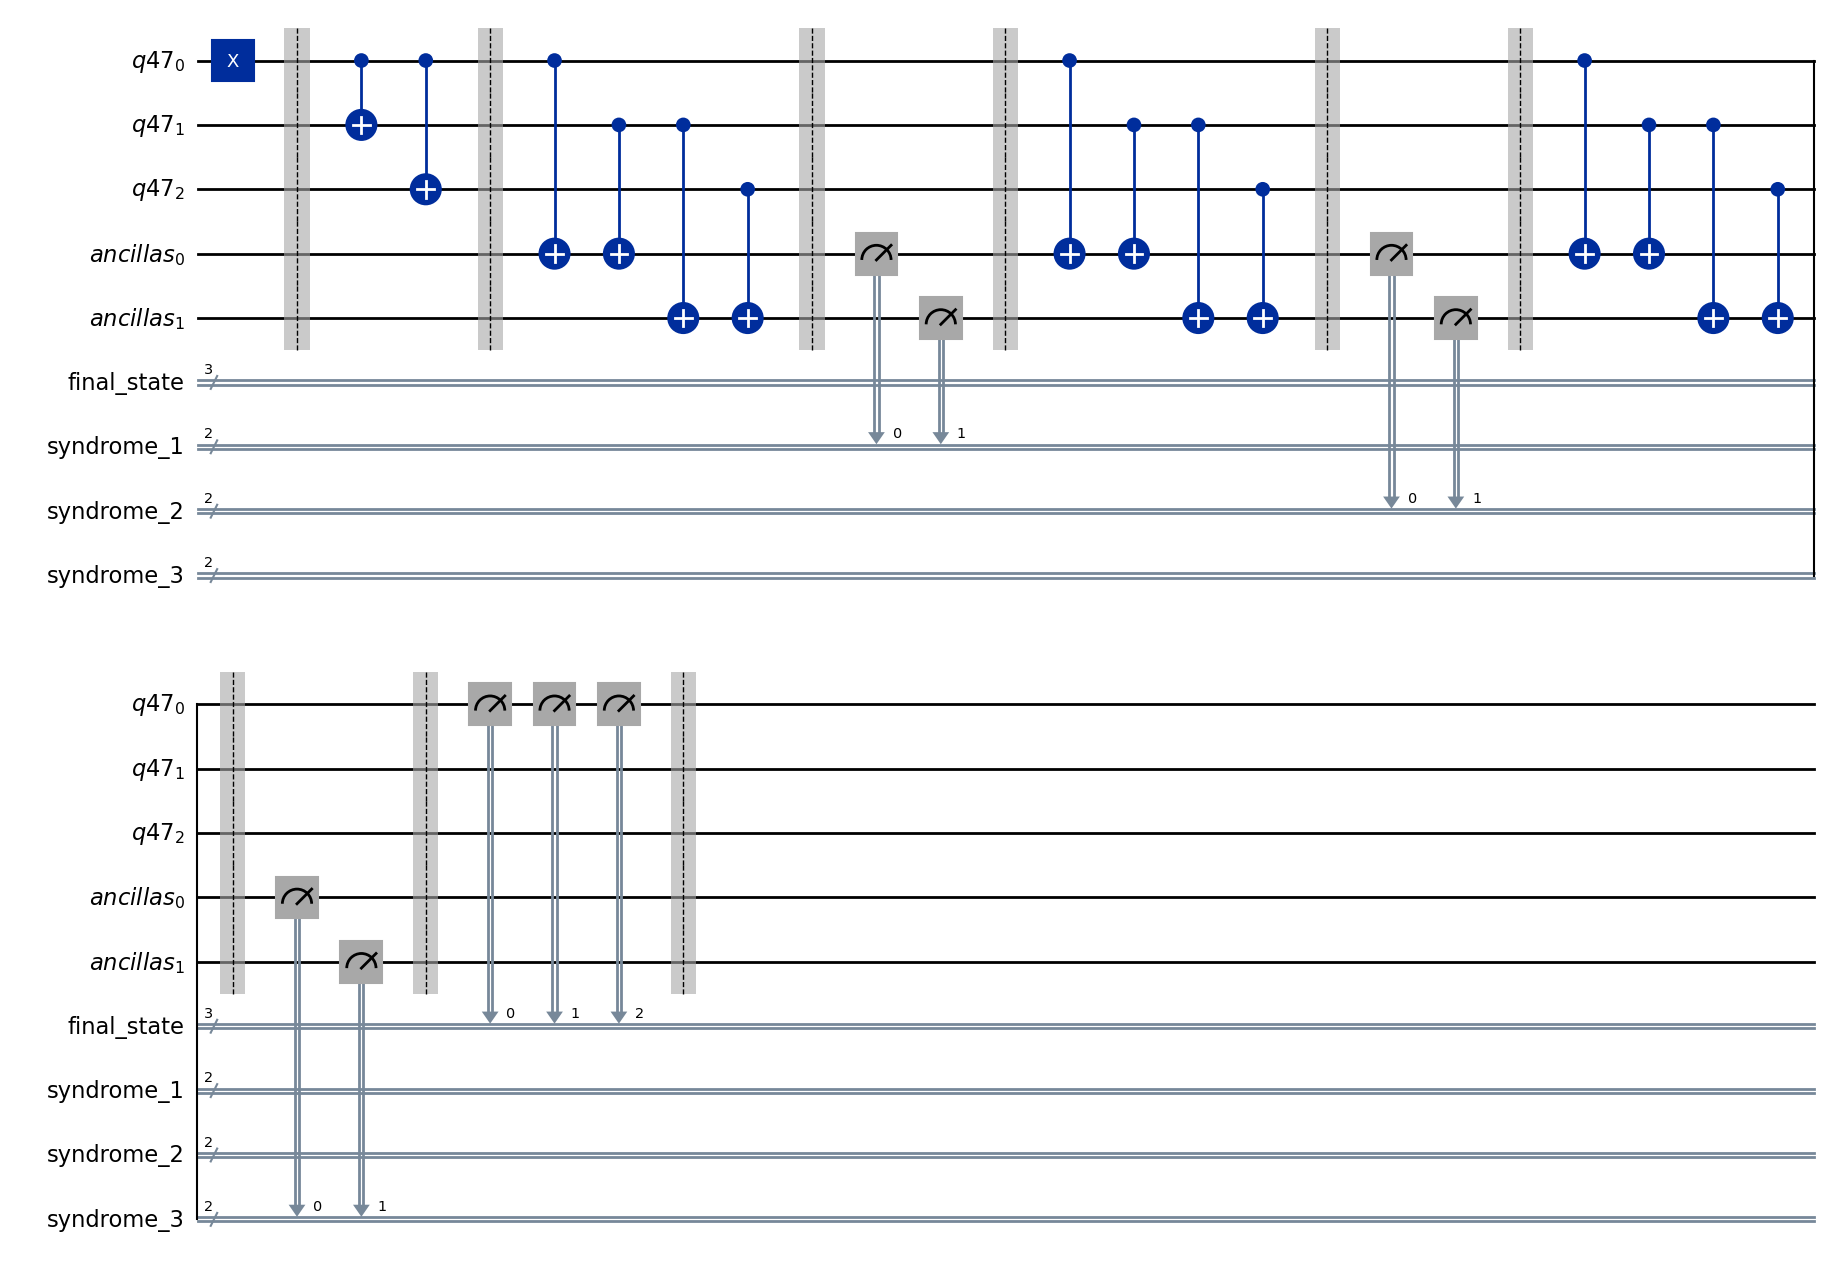

In [47]:
repetition_code = RepetitionCode(d=3, repetitions=2)
qc = repetition_code.build_circuit()
qc.draw(output='mpl',style='iqp')

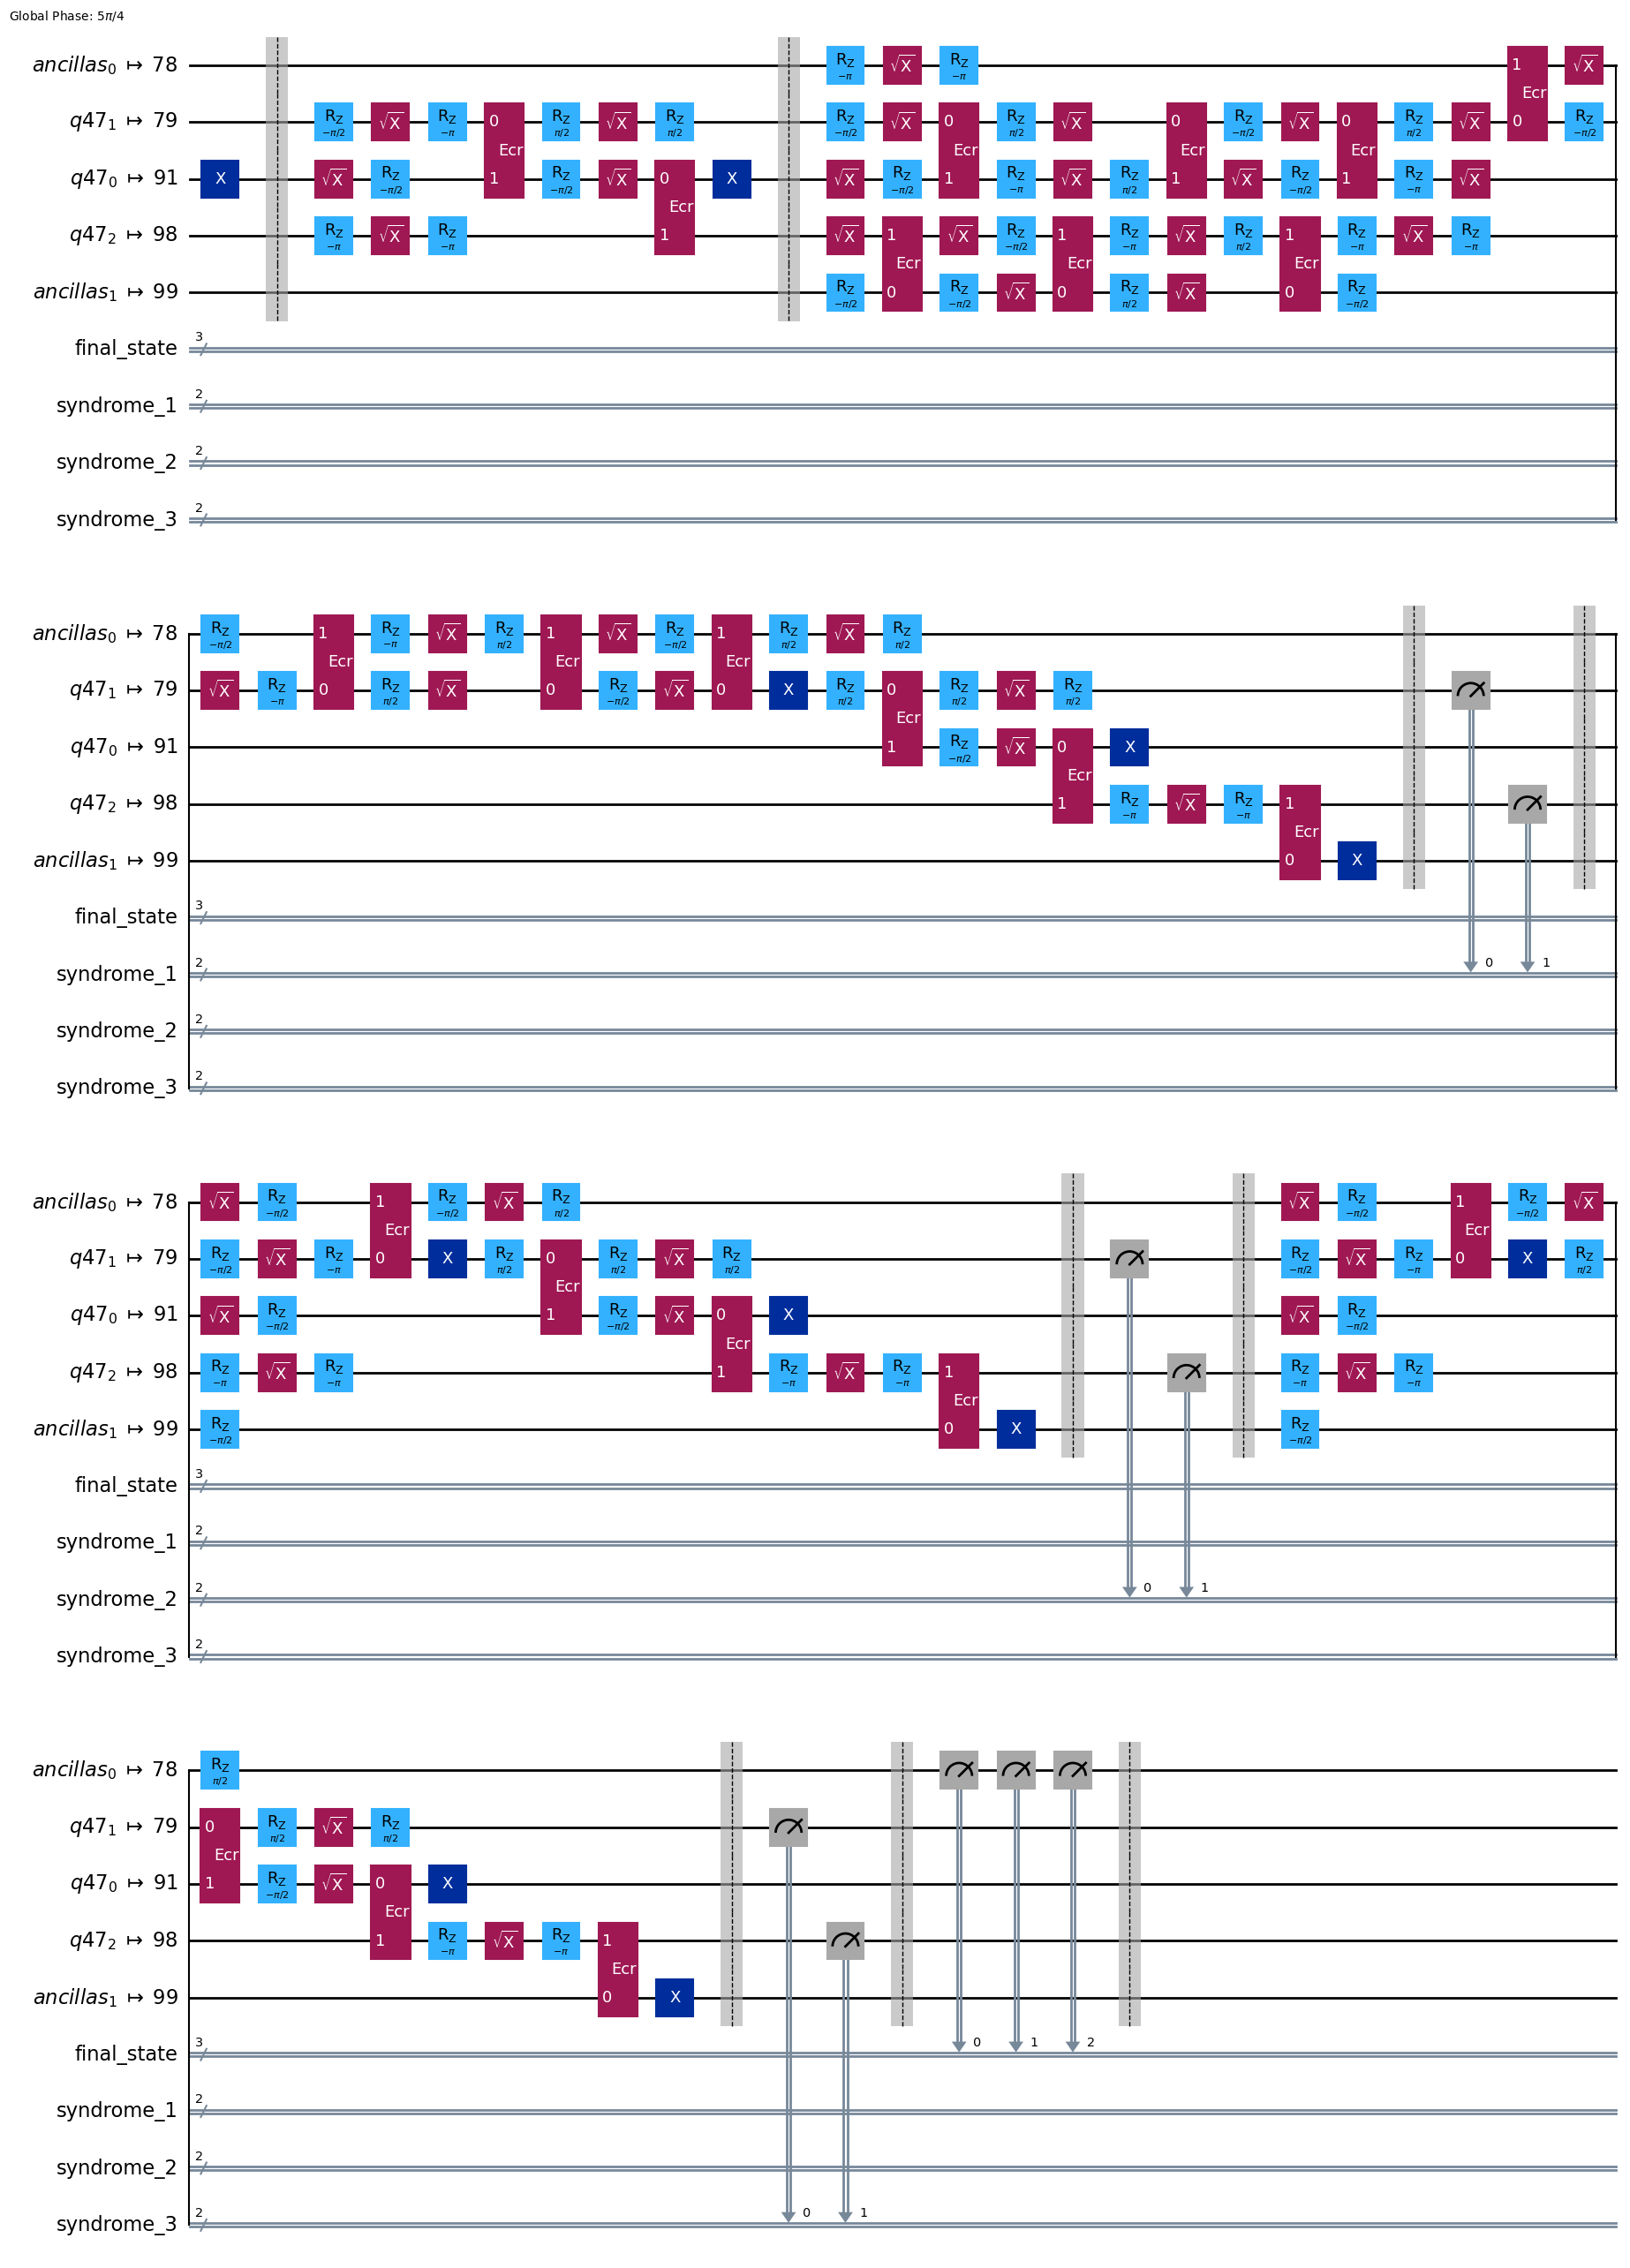

In [48]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', style='iqp', idle_wires=False)

In [49]:
repetition_code = RepetitionCode(d=3, repetitions=2)
qc = repetition_code.build_circuit()
no_correction_circuit = qc

isa_no_correction_circuit = pm.run(no_correction_circuit)

In [50]:
sampler_no_correction = Sampler(backend)
job_no_correction = sampler_no_correction.run([isa_no_correction_circuit], shots=1000)
result_no_correction = job_no_correction.result()[0]

In [52]:
print(result_no_correction.data.syndrome_1.get_counts())
print(result_no_correction.data.syndrome_2.get_counts())
print(result_no_correction.data.syndrome_3.get_counts())
print(result_no_correction.data.final_state.get_counts())

{'01': 54, '11': 449, '00': 375, '10': 122}
{'11': 38, '00': 595, '01': 319, '10': 48}
{'01': 141, '10': 195, '11': 390, '00': 274}
{'000': 423, '100': 5, '111': 537, '011': 10, '101': 5, '001': 11, '010': 1, '110': 8}


In [ ]:
print(result_no_correction.data.final_state.get_counts())

In [72]:
syndromes_1 = []
syndromes_2 = []
syndromes_3 = []
finalstate = []
shots  = 1000
for i in range(shots-1):

    syndromes_1.append(result_no_correction.data.syndrome_1.get_counts(i))
    syndromes_2.append(result_no_correction.data.syndrome_2.get_counts(i))
    syndromes_3.append(result_no_correction.data.syndrome_3.get_counts(i))
    finalstate.append(result_no_correction.data.final_state.get_counts(i))


syndrome_list_1 = [int(list(item.keys())[0]) for item in syndromes_1]

syndrome_list_2 = [int(list(item.keys())[0]) for item in syndromes_2]

syndrome_list_3 = [(list(item.keys())[0]) for item in syndromes_3]


finalstate_list = [list(item.keys())[0] for item in finalstate]
final_state=  [int(m[0]) for m in finalstate_list]
print(final_state)

syndrome_12, syndrome_23 = [int(m[0]) for m in syndrome_list_3],[int(m[1]) for m in syndrome_list_3]
print(syndrome_12)
print(syndrome_23)
print(syndrome_list_3)

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 

In [ ]:
def flippade_kvantbitar(syndrome_list, q2_measured, original_state):
    """
    Beäknar vilka kvantbtar som blivit flippade. Givet en syndrommätning och en kvantbitstillstånd

    :param syndrome_12: Sista syndrome mätningarna
    :param q2_measured: mittersta qubiten (första egentligen)
    :param original_state: logiska kvantbitens begynnelsetillstånd
    :return: Lista med flippade kvantbitar
    """
    flip_results = []
    syndrome_12, syndrome_23 = [int(m[0]) for m in syndrome_list], [int(m[1]) for m in syndrome_list] # Tar ut sydnrommätningar för sig

    for S12, S23, q2 in zip(syndrome_12, syndrome_23, q2_measured):
        if q2 == original_state:  # Fall 1: q2 är i "rätt" tillstånd
            if S12 == 0:
                if S23 == 0:
                    flip_results.append([0])  # Ingen flip
                else:  # S23 == 1
                    flip_results.append([3])  # Qubit 3 flippad
            else:  # S12 == 1
                if S23 == 0:
                    flip_results.append([1])  # Qubit 1 flippad
                else:  # S23 == 1
                    flip_results.append([2])  # Qubit 2 flippad
        
        else:                   #Fall 2: q2 är ej i "rätt" tillstånd
            if S12 == 0:           
                if S23 == 0:
                    flip_results.append([1, 2, 3])  # Alla är flippade
                else:  # S23 == 1
                    flip_results.append([1, 2])  # Qubits 1 och 2 flippad
            else:  # S12 == 1
                if S23 == 0:
                    flip_results.append([2, 3])  # Qubits 2 och 3 flippad
                else:  # S23 == 1
                    flip_results.append([2])  # Qubit 2 flippad

    return flip_results


syndrome_list = syndrome_list_3 # Lista över Sista sydnormmätningen
q2_measured = final_state   # Mitten kvantbitens tillstånd
original_state = 1           # logiska kvantbitens begynnelsetillstånd

flipped_qubits = flippade_kvantbitar(syndrome_list, q2_measured, original_state)
print("Flippade kvantbitar:", flipped_qubits)


Flippade kvantbitar: [[1, 2], [2, 3], [2], [1, 2, 3], [2], [2], [2], [1, 2, 3], [2, 3], [1, 2, 3], [2], [2], [1, 2, 3], [3], [2], [1, 2, 3], [1, 2, 3], [1, 2, 3], [3], [0], [0], [2], [2], [1, 2], [0], [2], [2, 3], [2, 3], [2, 3], [1, 2], [1, 2], [3], [1], [2], [3], [3], [2], [2, 3], [3], [2], [2], [2], [0], [2], [2, 3], [1, 2], [2], [0], [2, 3], [1, 2, 3], [2], [2], [3], [1, 2], [3], [2], [1, 2, 3], [2], [2], [2, 3], [1, 2, 3], [2], [2], [2], [1, 2], [1, 2, 3], [1, 2], [0], [1, 2, 3], [2], [2], [2], [2], [2, 3], [1, 2], [0], [1], [1, 2, 3], [2, 3], [1, 2, 3], [0], [0], [2], [0], [1, 2], [2], [3], [1], [2], [2], [2], [2, 3], [2, 3], [0], [1, 2, 3], [0], [2], [0], [1, 2, 3], [0], [0], [0], [1, 2, 3], [1, 2, 3], [0], [2], [2], [2], [0], [2], [3], [2], [2, 3], [1, 2, 3], [1], [1], [2], [2], [1], [2], [2], [2], [2, 3], [2, 3], [0], [2, 3], [2], [1], [0], [2], [1, 2, 3], [2, 3], [2], [1, 2], [1, 2], [3], [2], [2], [1, 2, 3], [2, 3], [1, 2, 3], [0], [2, 3], [0], [3], [2], [0], [1], [2], [1, 2